# Projet Getaround: Analyse des delais

Dans le cadre de l'instauration d'un **délai minimum entre deux locations** il nous faut évaluer l'impact que cela pourrait avoir sur les utilisateurs et les locations.

## Import des modules

In [1]:
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

# Some summary libs
from summarytools import dfSummary
from skimpy import skim

from config import (
    JEDHA_GETAROUND_DELAY_DATASET_CSV_URL,
    LOCAL_GETAROUND_DELAY_DATASET_CSV_PATH,
)

# display settings
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', 1000)          # Expand display width
pd.set_option('display.max_colwidth', None)   # Show full content in each cell

Data folder: /workspaces/jedha-cdsd-cert-projects/bloc-5/Getaround/data


## Chargement des données

In [2]:
# Retrieve locally data analysis dataset
if not LOCAL_GETAROUND_DELAY_DATASET_CSV_PATH.exists():
    response = requests.get(JEDHA_GETAROUND_DELAY_DATASET_CSV_URL)

    with open(LOCAL_GETAROUND_DELAY_DATASET_CSV_PATH, mode="wb") as file:
        file.write(response.content)

In [3]:
# Be sure to always load the data sheet (named 'rentals_data')
delay_analysis_raw_df = pd.read_excel(LOCAL_GETAROUND_DELAY_DATASET_CSV_PATH, sheet_name="rentals_data")

delay_analysis_raw_df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


Documentation provided withing sheet `Documentation`:

| field name | Comment |
| - | - |
rental_id | Unique identifier of the rental
car_id | Unique identifier of the car
checkin_type | Flow used for both checkin and checkout. (ie. access and return the car)<br>- ***mobile*** = rental agreement signed on the owner's smartphone <br>- ***connect*** = car equiped with the Connect technology , opened by the driver with his smartphone.<br><u>**Note:**</u> paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case
state | canceled means that the rental did not happen (was canceled by the driver or the owner).
delay_at_checkout_in_minutes | Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
previous_ended_rental_id | id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
time_delta_with_previous_rental_in_minutes | Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)


## Exploration et adaptation rapide des données

### Statistiques

In [4]:
dfSummary(delay_analysis_raw_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,rental_id[int64],Mean (sd) : 549712.9 (13863.4)min < med < max:504806.0 < 550350.0 < 576401.0IQR (CV) : 19855.2 (39.7),"21,310 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAArZJREFUeJzt3buO2kAUgOEzYQFziS1EBJ1fIFIKSpq8QR42bbot4AV4AxqEhMAIsggwpNpoE21YmEvWx/xf72WKX8YzWHvM+XwWoOg+vPcCgGs8vPcCysgY0xCRmuXl+/P5/ORzPWVAqJ4ZYxrdbvdbHMcdm+tXq9XGGPNDRHaWSyhl6ITqXy2O485wOHxKkuSm2Gaz2cfxePw1TdNPlUrFKtT1er00xnwvW6yEGkiSJLter/fzlmuWy2UjiqLmYDDY9fv95a2fmWVZNBqNOovFoiYihIqwWq3WzZE/y/M8FpHYGGNzeWEfGwi1RLbbbfVwOHxJ07Ri8+hQ5McGQi2R/X7/YPvoUPTHBkItIYdHh4b3xXjCgT9U4I6K3/I8r4r9Rkwk4GaMUCEi7hsxkbCbMUKFiLhtxETCb8YIFX9wOcOVgJsxQv0HhxdL4tPpVPW9nntHqK9webHkcDhEeZ5/3u12jyJie2fCXwj1ddYvlkyn085kMmkej8dKqMXdI0K9wPbFklDruWcc+EMFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSowL+dhDeOU1UuTlQhVHgRerwlocKL0OMtCRVehRpvWdpQHaaaiDDZpHBKGarLVBMRJpsUUSlDFYepJiJMNimisoYqInZTTUSYbFJEHPhDBUKFCoX+6mceKZ4VNlTmkeKlwoYqzCPFC0FD9XHoniTJknmkCBYqh+7w6c1QXTY07Xa7NxwO1xy6w9XFUH1saOr1+iOH7nD11h2VDQ0K4apnVJufIrkjwid+mYIKV91RsyyLbv3Dm80mEhHZbrfRfD5v/s/rtX621nW7Xn9NX78A2tibKkTAOg4AAAAASUVORK5CYII="">",0(0.0%)
2,car_id[int64],Mean (sd) : 350030.6 (58206.2)min < med < max:159250.0 < 368717.0 < 417675.0IQR (CV) : 77289.0 (6.0),"8,143 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAApJJREFUeJzt3b2O2kAUQOFrkgWzWLb4CTxAyu2QaPwAKfOweYQtKFJTpElFh4QsWziLAsapEiXSwuIZO55rna9Fs7g4QnuZmV2vLEsBXNdr+wGAe7xv+wHQHZ7nDUWkb7j8Z1mWL9deJFTUwvO84XQ6/RyG4dhkfZZlied5X67FSqioSz8Mw3Ecxy9RFB2rLEzT1F+v1+P9ft8XEUJF86IoOs7n8x8GS4e3XmSYggqEChUIFSoQKlQgVKhAqFCBUKECoUIFvvDHH5Z79eHlcnmo83n+RqgQEfu9+tPp5BdF8XQ8Hp9FxGRn6iZCxW/Ge/UiItvtdrzZbB7P5/O7Jh6OUPEP0736JElu7tXbYpiCCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFDk53jMW9p0bvPNki1A6xuffU9J0nW4TaLcb3npq+82SLUDvI5N5T03eebDFMQQVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFdqYc4/If020ToTbAIjZ/Mpl8iqJoZPK+rh8ssUGoNbM9wSQiT6vV6utsNsuqrnf9YIkNQq2f9Qkm3/dPLv4x3TYRakO6eIKpTUz9UIFQoQKhQgVChQqEChWY+q/o6rVjrQj1FV2+dqwVob6us9eOtSLUG/jS3h0MU1DB6U9UyyNvPRG5GK5lIHKMs6HaDDRFUTzkef4xCILvvV7vVHU9A5F7Gg3V9hBwEATzOI4zw4Hmw3K5/LZYLJKqb8xA5J43Q237EPBgMHg2HWhGo5GT/3se1d0MlUPAcMVbn6gcAoYT7vodle8T0ba7Qk3T1K/6gw+Hgy8ikue5v9vtHv/neq3vrfW5bdff09cvyzxd/yS7j8IAAAAASUVORK5CYII="">",0(0.0%)
3,checkin_type[object],1. mobile2. connect,"17,003 (79.8%)4,307 (20.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAS5JREFUeJzt28Fpw0AQRuHZIEx82UUIVIyKSLEpYrsRQnuIjS/KITXkzcHva2AMfjbY6C/XdYVEKBFxj4hb9gsR5nVd1yPj8LQsy1etdc44Lt4Y4yilfGcEN9Va523bHq21J31crPM8P3vv877vt4jgY4uIaK0913X9oY8rxT3r8EfWYb0fYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2ISZIv4eqst+Ifp/2e/zNMY4eu9zJD5UJ84Y44iIV8ZtBy/vJ23wUpzyiZL9zZb2KRMvdcqXOSsTL23Klz0rEy97yucv4Dfin7rCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiZM2pQve1YmXuqUL3NWJp6DF2F+AQpbat/wGm4yAAAAAElFTkSuQmCC"">",0(0.0%)
4,state[object],1. ended2. canceled,"18,045 (84.7%)3,265 (15.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAATVJREFUeJzt28GJwzAYROHRYsLmImEMLsZFbLFbhLsxxjokIRftYS9u4B9H8L4CJB9eAgme1FoT4JAk3SXdrn4QfIR3a+0ZdfgwTdNPznmMugD9qLXuKaXfqOCGnPO4LMuzlPKKuAB9OI7je13Xcdu2m6SY2CSplPKa5/kRcQG6co88/CvycOCM2GBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGm0H6f3Hu6gfBtRwNDLXWfV3XUcEvzuHz1Vp3Se+o8xm84Cx08JKY8sHF8c0W+mlBP8KnfNHzMPQjdMrnmIehH44pH79yIYk/dWFEbLAhNtgQG2yIDTbEBhtig

In [5]:
skim(delay_analysis_raw_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 21310  │ │ float64     │ 3     │                                                          │
│ │ Number of columns │ 7      │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column       ┃ NA    ┃ NA %         ┃ mean   ┃ sd    ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ rental_id    │     0 │            0 │ 549700 │ 13860 │ 504800 │ 540600 │ 550400 │ 560500 │ 576400 │ ▁▁▅█▇▄ │  │
│ │ car_id       │     0 │            0 │ 350000 │ 58210 │ 159200 │ 317600 │ 368700 │ 394900 │ 417700 │ ▁▁▁▃▅█ │  │
│ │ delay_at_che │  4964 │ 23.294228061 │   59.7 │  1003 │ -22430 │    -36 │      9 │     67 │  71080 │    █   │  │
│ │ ckout_in_min │       │        94275 │        │       │        │        │        │        │        │        │  │
│ │ utes         │       │              │        │       │        │        │        │        │        │        │  │
│ │ previous_end │ 19469 │ 91.360863444 │ 550100 │ 13180 │ 505600 │ 540900 │ 550600 │ 560800 │ 575100 │ ▁▁▅██▅ │  │
│ │ ed_rental_id │       │        39231 │        │       │        │        │        │        │        │        │  │
│ │ time_delta_w │ 19469 │ 91.360863444 │  279.3 │ 254.6 │      0 │     60 │    180 │    540 │    720 │ █▄▂▁▂▅ │  │
│ │ ith_previous │       │        39231 │        │       │        │        │        │        │        │        │  │
│ │ _rental_in_m │       │              │        │       │        │        │        │        │        │        │  │
│ │ inutes       │       │              │        │       │        │        │        │        │        │        │  │
│ └──────────────┴───────┴──────────────┴────────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃             ┃    ┃      ┃          ┃          ┃          ┃        ┃ chars per   ┃ words per   ┃ total      ┃  │
│ ┃ column      ┃ NA ┃ NA % ┃ shortest ┃ longest  ┃ min      ┃ max    ┃ row         ┃ row         ┃ words      ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ checkin_typ │  0 │    0 │ mobile   │ connect  │ connect  │ mobile │         6.2 │           1 │      21310 │  │
│ │ e           │    │      │          │          │          │        │             │             │            │  │
│ │ state       │  0 │    0 │ ended    │ canceled │ canceled │ ended  │        5.46 │           1 │      21310 │  │
│ └─────────────┴────┴──────┴──────────┴──────────┴──────────┴────────┴─────────────┴─────────────┴────────────┘  │
╰────────────────────────────────────────────────────── 

On voit qu'il existe des valeurs vraissemblablement exceptionnelles pour `delay_at_checkout_in_minutes`: 
- en avance de 22433 minutes soit environ 15j!
- en retard de 71084 minutes soit environ 50 jours!

Des locations longue durée ?

### Outliers

In [6]:
def get_outliers_mask(df_in, col_name, keep_na=True):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    if keep_na:
        # df_out = df_in.loc[df_in[col_name].isna() | ((df_in[col_name] > fence_low) & (df_in[col_name] < fence_high))]
        mask_out = df_in[col_name].isna() | ((df_in[col_name] > fence_low) & (df_in[col_name] < fence_high))
    else:    
        # df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
        mask_out = (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    #return df_out
    return mask_out

In [7]:
outliers_mask = get_outliers_mask(delay_analysis_raw_df, "delay_at_checkout_in_minutes")

outliers_df = delay_analysis_raw_df[~outliers_mask]

print(f"Found {len(outliers_df)} outliers")

Found 2430 outliers


In [8]:
delay_analysis_df = delay_analysis_raw_df[outliers_mask].copy()

dfSummary(delay_analysis_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,rental_id[int64],Mean (sd) : 549702.9 (13920.9)min < med < max:504871.0 < 550383.5 < 576401.0IQR (CV) : 19889.8 (39.5),"18,880 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAr5JREFUeJzt3c9OGlEYhvH3FMFB6UwIBnfcQJMuXLLpHfRiu+1OEr0B78ANMSE4BCoBka7a2MYinD91vvH57Q+cxZODZybxc9vtVkDVfXjrDQD7OHrrDdSRc64tqeW5fLXdbh9i7qcOCDUy51y71+t9zfO867P+/v5+7pz7LmnpuYVahk6o8bXyPO8Oh8OHoigOim08Hn+8vr7+MhgMzhqNhleos9ls6pz7VrdYCTWRoiiW/X7/xyFrptNpO8uyk4uLi+X5+fn00O8syzIbjUb9yWRy5pybHbpeFT6NCbWCTk9PD45ckhaLRXO9Xn8eDAYNnxO5yqcxodbIarU68j2Ry7LMrq6uupPJpCWJUJGe74ksqR19M5HwHBUmcKLit81m05SUO+d8PyLZZYxQISn8IialvYwRKiSFXcSk9JcxQsUfAi5iUsLLGKH+Q8D7+vzp6akZez/vHaG+IOR9/Xq9zjabzaflcnkpyfdkwl8I9WXe7+tvb2+7Nzc3J4+Pj41Um3uPCHUH3/f1qfbznvHAHyYQKkwgVJhAqDCBUGECocIEQoUJhAoTCBUmECpMIFSYQKgwgVBhAqHCBEKFCYQKEwgVJhAqTCBUmECoMIFQYQKhwgRChQmEChMIFSYQKkwgVJhAqDCBUGECocIE/u0kogmcqrJzogqhIorU4y0JFVGkHm9JqIgq1XhLLlMwobYnasD4HYkRPJVTy1BDxu9IjOCpolqGqoDxOxIjeKqorqFK8hu/IzGCp4q4TMEEQoUJlf7pZ3AufqlsqAzOxXOVDVUMzsUzSUON8dC9KIopg3ORLFQeuiOmV0MNudB0Op3+cDic8dAdoXaGGuNCc3x8fMlDd4R67UTlQoNK2OtvVJ9XkZyIiIk3UzBhrxO1LMvs0A+ez+eZJC0Wi+zu7u7kf663+t1W9x26fp++fgIes5gaX7WJ8QAAAABJRU5ErkJggg=="">",0(0.0%)
2,car_id[int64],Mean (sd) : 350551.3 (57880.0)min < med < max:159250.0 < 369224.5 < 417675.0IQR (CV) : 76784.0 (6.1),"7,689 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAldJREFUeJzt3Mtu2kAYhuF/ekAmlWxxEDeRNRsuIMtebC+hCxZdcwfskBAygsQqB2eVqpUCgRm7nm/0Pls0wYtXVuz5B1fXtQGx+9T1BQC3+NL1BSAdzrm+mfU8l/+u6/rl0oeEikY45/qj0eh7nucDn/Xb7XbjnPtxKVZCRVN6eZ4PZrPZS1EU1T0Ly7LM5vP5YL1e98yMUNG+oiiqyWTy7LG0f+1DHqYggVAhgVAhgVAhgVAhgVAhgVAhgVAhgRf++CNwrz4/n89fm7yevxEqzCx8r/5wOGSn0+mxqqqfZuazM3UVoeKN9169mdlyuRwsFouH4/H4uY2LI1T8w3evfrPZXN2rD8XDFCQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQwOJ2YgHNPrZ55CkWoCQk599T2madQhJoW73NPbZ95CkWoCfI599T2madQPExBAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAjtTkYn5x3S7RKgtCIgtGw6HT0VRfPP53tgHS0IQasNCJ5jM7HE6nf4aj8fbe9fHPlgSglCbFzzBlGXZIcYf0+0SobYkxQmmLvHUDwmECgmECgmECgmECgmECgm8nrog1fPxqgj1HSmfj1dFqO9L9ny8KkK9gt2leCQbKuNyaYk6VMbl8KbVUAPvat6xMS6Xng9D7fKuZp6xMS6XnquhxjAE7BMboaXnozsqQ8CIwk3/o/KaBl27KdSyLLN7//But8vMzPb7fbZarR7+53rV71a97tD1t/T1Cm/iUpsG9VAEAAAAAElFTkSuQmCC"">",0(0.0%)
3,checkin_type[object],1. mobile2. connect,"15,018 (79.5%)3,862 (20.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAATJJREFUeJzt28GJwzAYROHRYsLmImEMLsZFbLFbhLoxxjokIRftYWvI/AK/rwEJ8hJw8KTeuwCHJOku6RZ9EVi8e+/PqMOnZVl+cs5z1AXg01o7Ukq/UcFNOed527ZnKeUVcQF4nOf5XWud932/SYqJTZJKKa91XR8RF4DVPfLwr8jDcS3EBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYTNL/i3XRF8FnjfAZT621o9Y6K/jFOnxea+2Q9I46n8HLtYQOXhJTPriM8MsW+m2DT/iUL3peBp/QKd8I8zL4jDDl4yn4IvhTFzbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYhE75RpiXwSd8yhc9L4MPgxfY/AEKW2rfrKycQQAAAABJRU5ErkJggg=="">",0(0.0%)
4,state[object],1. ended2. canceled,"15,616 (82.7%)3,264 (17.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAASpJREFUeJzt28Fpw0AUBuG3QZj4sosQqBgVkWJTxHYjhPYQG182h9Sg8ULma+AZPDbY6E+995AIKSLuEXF79wvR27x67w/i0LQsy1fOeSaOaTyttSOl9E0EN+Wc523bHqWU59XHNJbzPD9rrfO+77eIuD62iIhSynNd15+rj2lId+rQB3VIMjZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE2YKeLvIbp3vxDx6Pd9aq0dtdY5wIfoNI7W2hERL+KWgxdhg5fklE8U+psN+xRpPOiUj5yNaTzYlI+ejWk89JTPX7z/mH/qCmNswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMNiUz7mg0CkfORvTeBy8CPMLCltq31RnXuMAAAAAS

### Typage des colonnes

In [9]:
delay_analysis_df.dtypes

rental_id                                       int64
car_id                                          int64
checkin_type                                   object
state                                          object
delay_at_checkout_in_minutes                  float64
previous_ended_rental_id                      float64
time_delta_with_previous_rental_in_minutes    float64
dtype: object

In [10]:
# Enforce integers
delay_analysis_df['rental_id'] = delay_analysis_df['rental_id'].astype(pd.Int64Dtype())
delay_analysis_df['previous_ended_rental_id'] = delay_analysis_df['previous_ended_rental_id'].astype(pd.Int64Dtype())


In [11]:
delay_analysis_df.dtypes

rental_id                                       Int64
car_id                                          int64
checkin_type                                   object
state                                          object
delay_at_checkout_in_minutes                  float64
previous_ended_rental_id                        Int64
time_delta_with_previous_rental_in_minutes    float64
dtype: object

Le dataset `delay_analysis_df` ne contient plus que les données les plus pertinante au regard du delais de checkout. En effet, c'est ce temps qui impactera la possibilité d'enchainer avec succés des locations. Si le checkout est réalisé plus en retard que le début planifié de la prochaine location, c'est là qu'un conflit peut survenir.

## Un peu de visualisation

### Les modes de reservation

In [12]:
checkin_type_count = delay_analysis_df["checkin_type"].value_counts()

# Check we have only the 2 expected values
checkin_type_count

checkin_type
mobile     15018
connect     3862
Name: count, dtype: int64

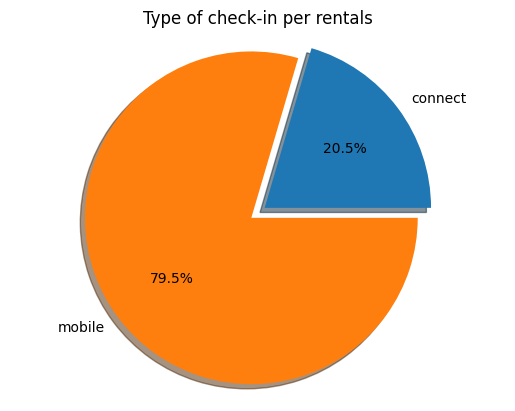

In [13]:
# Data to Plot
labels = "connect", "mobile"
sizes = [checkin_type_count["connect"], checkin_type_count["mobile"]]
explode = (0.05, 0.05)

# Plot
plt.pie(sizes, explode = explode, labels = labels, autopct = '%1.1f%%', shadow = True)
plt.axis('equal')
plt.title("Type of check-in per rentals")
plt.show()

**Mobile** seems to be the preferred way.

### Les annulations

In [14]:

# Check we have only the 2 expected values
state_count = delay_analysis_df["state"].value_counts()

print(state_count)
print("="*40)
print("All rentals are ended or cancled: ",  len(delay_analysis_df) == np.sum(state_count))


state
ended       15616
canceled     3264
Name: count, dtype: int64
All rentals are ended or cancled:  True


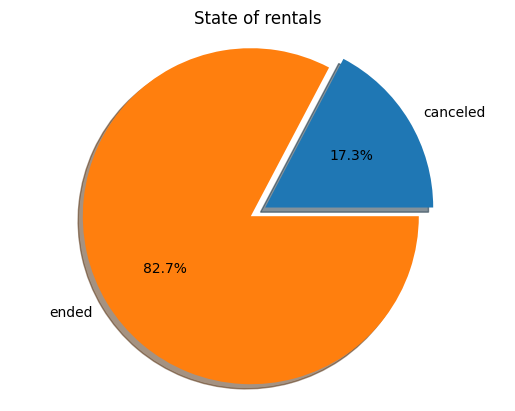

In [15]:
# Data to Plot
labels = "canceled", "ended"
sizes = [state_count["canceled"], state_count["ended"]]
explode = (0.05, 0.05)

# Plot
plt.pie(sizes, explode = explode, labels = labels, autopct = '%1.1f%%', shadow = True)
plt.axis('equal')
plt.title("State of rentals")
plt.show()

## Locations consécutives

Les données de consécutivité n'existent que lorsque 2 locations se sont succédé en moins de 12h.

![rental-timeline.png](./assets/rental-timeline.png)

Quelques valeurs ne font pas partie du dataset initial mais sont facilement calculables (et utiles):
- `previous_delay_at_checkout_in_minutes`: temps écoulé entre le checkout planifié et le checkout réel de la précédente location (le `delay_at_checkout_in_minutes` de `previous_ended_rental_id` s'il y lieu)
- `time_delta_with_previous_checkout_in_minutes`: temps écoulé entre le précédent checkout réel et le check-in planifié (si < 0, retard pour le checkin!)

Ces valeurs permettront une analyse plus fine des locations s'enchainant.

In [16]:
# Let quickly check previous_ended_rental_id and time_delta_with_previous_rental_in_minutes are provided together
previous_ended_rental_id_df = delay_analysis_df[delay_analysis_df["previous_ended_rental_id"].isna()]
time_delta_with_previous_rental_in_minutes_df = delay_analysis_df[delay_analysis_df["time_delta_with_previous_rental_in_minutes"].isna()]

previous_ended_rental_id_df.equals(time_delta_with_previous_rental_in_minutes_df)

True

### Feature engineering

Calcul/ajout de valeurs utiles à l'analyse:
- rajout du delais au checkout en cas de succession de location
- catégorisation des retards
- temps écoulé entre le précédent checkout réel et le checkin prévu (si < 0, retard pour le checkin!)

In [17]:
# Extend rentals with delay_at_checkout of previous rental when existing => previous_delay_at_checkout_in_minutes

# delay_at_checkout_in_minutes = (rental end time requested by the driver - actual time the driver completed the checkout) => Negative values mean that the driver returned the car in advance

# Cleanup in case or repeated run
delay_analysis_df.drop(columns="previous_delay_at_checkout_in_minutes", inplace=True, errors="ignore")

delay_analysis_df = delay_analysis_df.merge(
    delay_analysis_df[["rental_id", "delay_at_checkout_in_minutes"]].rename(columns={
        "rental_id": "previous_ended_rental_id",
        "delay_at_checkout_in_minutes": "previous_delay_at_checkout_in_minutes"
    }),
    on="previous_ended_rental_id",
    how="left"
)

# Calcul du delta réel entre le checkin et le précédent checkout s'il y en a un
#
# time_delta_with_previous_rental_in_minutes = (rental planned start time - previous rental planned end time) => when lower than 12 hours, NULL if higher
#
delay_analysis_df["time_delta_with_previous_checkout_in_minutes"] = delay_analysis_df["time_delta_with_previous_rental_in_minutes"] - delay_analysis_df["previous_delay_at_checkout_in_minutes"]

In [18]:
# Categorizing checkout delay
def map_delay_to_status(delay):
    if pd.isna(delay):
        return "free"
    elif delay < 0:
        return "in-advance"
    elif delay == 0:
        return "on-time"
    else:
        return "delayed"

# Categorizing time_delta for checkin
def map_time_delta_to_status(time_delta):
    if time_delta < 0:
        return "checkin-delayed"
    else: # NA or >= 0
        return "checkin-ok"

# delay_at_checkout
delay_analysis_df["delay_at_checkout_status"] = delay_analysis_df["delay_at_checkout_in_minutes"].map(map_delay_to_status)
delay_analysis_df["previous_delay_at_checkout_status"] = delay_analysis_df["previous_delay_at_checkout_in_minutes"].map(map_delay_to_status)

# time_delta
delay_analysis_df["time_delta_with_previous_checkout_status"] = delay_analysis_df["time_delta_with_previous_checkout_in_minutes"].map(map_time_delta_to_status)

In [19]:
delay_analysis_df

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,previous_delay_at_checkout_in_minutes,time_delta_with_previous_checkout_in_minutes,delay_at_checkout_status,previous_delay_at_checkout_status,time_delta_with_previous_checkout_status
0,505000,363965,mobile,canceled,NaN,<NA>,NaN,NaN,NaN,free,free,checkin-ok
1,507750,269550,mobile,ended,-81.0,<NA>,NaN,NaN,NaN,in-advance,free,checkin-ok
2,508131,359049,connect,ended,70.0,<NA>,NaN,NaN,NaN,delayed,free,checkin-ok
3,508865,299063,connect,canceled,NaN,<NA>,NaN,NaN,NaN,free,free,checkin-ok
4,511440,313932,mobile,ended,NaN,<NA>,NaN,NaN,NaN,free,free,checkin-ok
...,...,...,...,...,...,...,...,...,...,...,...,...
18875,573322,376491,connect,ended,-66.0,<NA>,NaN,NaN,NaN,in-advance,free,checkin-ok
18876,573446,380069,mobile,ended,NaN,573429,300.0,NaN,NaN,free,free,checkin-ok
18877,573791,364890,mobile,ended,144.0,<NA>,NaN,NaN,NaN,delayed,free,checkin-ok
18878,574852,362531,connect,ended,-76.0,<NA>,NaN,NaN,NaN,in-advance,free,checkin-ok


### Reduction du dataset

On restreint le dataset aux locations enchainées uniquement.

In [20]:
# Locations en chaine
chained_rentals_df = delay_analysis_df[delay_analysis_df["previous_ended_rental_id"].notna()]

chained_rentals_count = len(chained_rentals_df)

chained_rentals_delta_time_max = chained_rentals_df["time_delta_with_previous_rental_in_minutes"].max()
chained_rentals_delta_time_max_str = "{:02.0f}h:{:02.0f}".format(*divmod(chained_rentals_delta_time_max, 60))

print(f"Dans notre dataset filtré il y a {chained_rentals_count} locations en suivant une autre à moins de {chained_rentals_delta_time_max_str} d'intervalle.")

Dans notre dataset filtré il y a 1642 locations en suivant une autre à moins de 12h:00 d'intervalle.


In [21]:
# Vizualisation of planned time delta
chained_df_count = chained_rentals_df["time_delta_with_previous_rental_in_minutes"].value_counts()
print("Nombre de locations: ", chained_df_count.sum())
print()
print("Distribution des locations en fonction de l'intervale planifié avec la précédente: ")
display(chained_df_count)

fig = px.bar(chained_df_count, y = "count", x=chained_df_count.index, labels=chained_df_count.index)
fig.show()

Nombre de locations:  1642

Distribution des locations en fonction de l'intervale planifié avec la précédente: 


time_delta_with_previous_rental_in_minutes
0.0      248
60.0     164
120.0    121
720.0    113
30.0     109
180.0     76
90.0      68
600.0     67
660.0     64
240.0     60
690.0     57
150.0     57
630.0     46
210.0     43
570.0     41
480.0     38
300.0     37
270.0     36
420.0     36
360.0     36
510.0     34
540.0     33
330.0     23
450.0     22
390.0     13
Name: count, dtype: int64

### Exploration

In [22]:
# How often are drivers late for the next check-in? How does it impact the next driver?

late_df = chained_rentals_df[["rental_id", "checkin_type", "previous_delay_at_checkout_status", "time_delta_with_previous_checkout_status"]].copy()

late_df["previous_delay_at_checkout_status"] = late_df["previous_delay_at_checkout_status"].map(lambda x: "delayed" if x == "delayed" else "not-delayed")
late_count_df = late_df.groupby(["checkin_type", "previous_delay_at_checkout_status", "time_delta_with_previous_checkout_status"]).count().reset_index()  
late_count_df.rename(columns={"rental_id": "rental_count"}, inplace=True)

display(late_count_df)

display(late_count_df[["checkin_type", "previous_delay_at_checkout_status", "rental_count"]].groupby(["checkin_type", "previous_delay_at_checkout_status"]).sum())

display(late_count_df[["checkin_type", "rental_count"]].groupby(["checkin_type"]).sum())

display(late_count_df[["previous_delay_at_checkout_status", "rental_count"]].groupby(["previous_delay_at_checkout_status"]).sum())


,checkin_type,previous_delay_at_checkout_status,time_delta_with_previous_checkout_status,rental_count
0,connect,delayed,checkin-delayed,54
1,connect,delayed,checkin-ok,201
2,connect,not-delayed,checkin-ok,482
3,mobile,delayed,checkin-delayed,101
4,mobile,delayed,checkin-ok,345
5,mobile,not-delayed,checkin-ok,459


rental_count
checkin_type previous_delay_at_checkout_status              
connect      delayed                                     255
             not-delayed                                 482
mobile       delayed                                     446
             not-delayed                                 459

,rental_count
checkin_type,
connect,737
mobile,905


,rental_count
previous_delay_at_checkout_status,
delayed,701
not-delayed,941


Check-in via `connect`:
- 255 locations sur 737 sont en retard au checkout.
- 54 locations sur 737 sont impactées par un retard au checkout.

Check-in via `mobile`:
- 446 locations sur 905 sont en retard au checkout.
- 101 locations sur 905 sont impactées par un retard au checkout.

In [23]:
canceled_df = chained_rentals_df[chained_rentals_df["state"] == "canceled"]
delay_canceled_stats_df = canceled_df[["rental_id", "checkin_type", "previous_delay_at_checkout_status", "time_delta_with_previous_checkout_status"]].groupby(["checkin_type", "previous_delay_at_checkout_status", "time_delta_with_previous_checkout_status"]).count()

ended_df = chained_rentals_df[chained_rentals_df["state"] == "ended"]
delay_ended_stats_df = ended_df[["rental_id", "checkin_type", "previous_delay_at_checkout_status", "time_delta_with_previous_checkout_status"]].groupby(["checkin_type", "previous_delay_at_checkout_status", "time_delta_with_previous_checkout_status"]).count()

print("="*85)
print("Distribution des locations annulées:")
display(delay_canceled_stats_df)

print("="*85)
print("Distribution des locations realisées:")
display(delay_ended_stats_df)

Distribution des locations annulées:


rental_id
checkin_type previous_delay_at_checkout_status time_delta_with_previous_checkout_status           
connect      delayed                           checkin-delayed                                  13
                                               checkin-ok                                       32
             free                              checkin-ok                                       40
             in-advance                        checkin-ok                                       46
mobile       delayed                           checkin-delayed                                  11
                                               checkin-ok                                       32
             free                              checkin-ok                                       29
             in-advance                        checkin-ok                                       26

Distribution des locations realisées:


rental_id
checkin_type previous_delay_at_checkout_status time_delta_with_previous_checkout_status           
connect      delayed                           checkin-delayed                                  41
                                               checkin-ok                                      169
             free                              checkin-ok                                       96
             in-advance                        checkin-ok                                      292
             on-time                           checkin-ok                                        8
mobile       delayed                           checkin-delayed                                  90
                                               checkin-ok                                      313
             free                              checkin-ok                                      156
             in-advance                        checkin-ok                                      242
             on-time                           checkin-ok                                        6

Lorsque le statut `previous_delay_at_checkout` est `delayed` et que le statut `time_delta` est `checkin-delayed`, celà signifie que le départ de la location a été impacté par le retard précédent.

### Impact du "rental delta"

Quelles locations seraient affectées par l'instauration d'un delais tampon entre 2 locations:
- nb de locations qui n'auraient plus lieu (celles qui suivent immédiatement ou quasiment la location précédente)
- nb de locations qui pourraient avoir lieu à l'heure (sans attente pour un retard)

Evaluons l'impact du futur `min_time_delta_with_previous_rental_in_minutes` sur les locations:
- combien de locations planifiées se verraient décalées du fait de ce delta (locations devant partir lors d'un check-in à l'heure)
- combien de locations (on-time) se verraient décalées du fait de ce delta (locations étant parties lors d'un check-in à l'heure)
- combien de check-ins retardées seraient évitées (locations étant parties durant ce délais, lors d'un check-in en retard due à un retard de checkout)
- combien de location effectivement rendues en retard dans ce delai
- combien de location ne sont pas affectées (départ au dela de ce délais)

In [24]:
df = chained_rentals_df[(chained_rentals_df["time_delta_with_previous_checkout_in_minutes"] >= 0) & (chained_rentals_df["time_delta_with_previous_checkout_in_minutes"] < 30)]

df

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,previous_delay_at_checkout_in_minutes,time_delta_with_previous_checkout_in_minutes,delay_at_checkout_status,previous_delay_at_checkout_status,time_delta_with_previous_checkout_status
94,537576,397470,mobile,ended,18.0,539005,0.0,-29.0,29.0,delayed,in-advance,checkin-ok
404,561368,249274,connect,ended,-3.0,558711,30.0,10.0,20.0,in-advance,delayed,checkin-ok
545,567120,415953,mobile,ended,27.0,567178,150.0,145.0,5.0,delayed,delayed,checkin-ok
554,567636,376840,connect,ended,101.0,564959,0.0,-2.0,2.0,delayed,in-advance,checkin-ok
985,539618,297119,mobile,ended,101.0,538807,30.0,7.0,23.0,delayed,delayed,checkin-ok
...,...,...,...,...,...,...,...,...,...,...,...,...
17972,567264,410255,connect,ended,183.0,564975,0.0,-19.0,19.0,delayed,in-advance,checkin-ok
18024,561334,410939,connect,ended,-157.0,565171,0.0,-15.0,15.0,in-advance,in-advance,checkin-ok
18172,542314,388111,mobile,ended,38.0,509727,30.0,25.0,5.0,delayed,delayed,checkin-ok
18393,551116,390467,connect,canceled,NaN,548851,0.0,-16.0,16.0,free,in-advance,checkin-ok


In [25]:
# On utilise un step de 30 minutes afin de calculer l'impact sur l'ensemble des locations
min_time_delta_thresholds = [td for td in range(0, 720, 30)]

# impacted_planned_rentals_count
# impacted_real_on_time_rentals_count
# impacted_real_checkin_delayed_rentals_count
# impacted_planned_checkout_delayed_rentals_count
# unimpacted_rentals_count
def compute_rental_delta_impact(checkin_type, rental_delta_in_minutes, df):
    # planned: time_delta_with_previous_rental_in_minutes
    # real: time_delta_with_previous_checkout_in_minutes
    
    impacted_df = df[df["checkin_type"] == checkin_type]
    
    
    planned_rentals_df = impacted_df[impacted_df["time_delta_with_previous_rental_in_minutes"] < rental_delta_in_minutes]

    real_rentals_df = impacted_df[(impacted_df["time_delta_with_previous_checkout_in_minutes"] >= 0) & (impacted_df["time_delta_with_previous_checkout_in_minutes"] < rental_delta_in_minutes)]

    impacted_planned_rentals_count = len(planned_rentals_df)
    
    # checkin-ok
    impacted_real_on_time_rentals_count = len(real_rentals_df[real_rentals_df["time_delta_with_previous_checkout_status"] == "checkin-ok"])
    # checkin-delayed (location rendue trop en retard par rapport au checkin planifié)
    impacted_real_checkin_delayed_rentals_count = len(planned_rentals_df[planned_rentals_df["time_delta_with_previous_checkout_status"] == "checkin-delayed"])
    
    # Location précédente rendue en retard dans l'intervale du rental_delta
    impacted_planned_checkout_delayed_rentals_count = len(planned_rentals_df[(planned_rentals_df["delay_at_checkout_in_minutes"] > 0) & (planned_rentals_df["delay_at_checkout_in_minutes"] < rental_delta_in_minutes)])
    impacted_planned_previous_checkout_delayed_rentals_count = len(planned_rentals_df[(planned_rentals_df["previous_delay_at_checkout_in_minutes"] > 0) & (planned_rentals_df["previous_delay_at_checkout_in_minutes"] < rental_delta_in_minutes)])
    # impacted_checkout_delayed_rentals_count

    # Split by check-in type ?
    
    return {
        "checkin_type": checkin_type,
        "impacted_planned_rentals_count": impacted_planned_rentals_count,
        "impacted_real_on_time_rentals_count": impacted_real_on_time_rentals_count,
        "impacted_real_checkin_delayed_rentals_count": impacted_real_checkin_delayed_rentals_count,
        "impacted_planned_checkout_delayed_rentals_count": impacted_planned_checkout_delayed_rentals_count,
        "impacted_planned_previous_checkout_delayed_rentals_count": impacted_planned_previous_checkout_delayed_rentals_count,
    } 

rental_delta_impact = []

for min_rental_delta_t in min_time_delta_thresholds:
    row = compute_rental_delta_impact("mobile", min_rental_delta_t, chained_rentals_df)
    row["rental_delta"] = min_rental_delta_t
    rental_delta_impact.append(row)
    
    row = compute_rental_delta_impact("connect", min_rental_delta_t, chained_rentals_df)
    row["rental_delta"] = min_rental_delta_t
    rental_delta_impact.append(row)

rental_delta_impact_df = pd.DataFrame(rental_delta_impact)    

rental_delta_impact_df

,checkin_type,impacted_planned_rentals_count,impacted_real_on_time_rentals_count,impacted_real_checkin_delayed_rentals_count,impacted_planned_checkout_delayed_rentals_count,impacted_planned_previous_checkout_delayed_rentals_count,rental_delta
0,mobile,0,0,0,0,0,0
1,connect,0,0,0,0,0,0
2,mobile,130,60,63,32,40,30
3,connect,118,53,34,13,20,30
4,mobile,192,119,78,67,77,60
5,connect,165,91,41,43,42,60
6,mobile,284,176,89,111,124,90
7,connect,237,123,48,73,58,90
8,mobile,319,220,92,141,149,120
9,connect,270,162,51,95,78,120


In [26]:
rental_delta_impact_df.columns

Index(['checkin_type', 'impacted_planned_rentals_count', 'impacted_real_on_time_rentals_count', 'impacted_real_checkin_delayed_rentals_count', 'impacted_planned_checkout_delayed_rentals_count', 'impacted_planned_previous_checkout_delayed_rentals_count', 'rental_delta'], dtype='object')

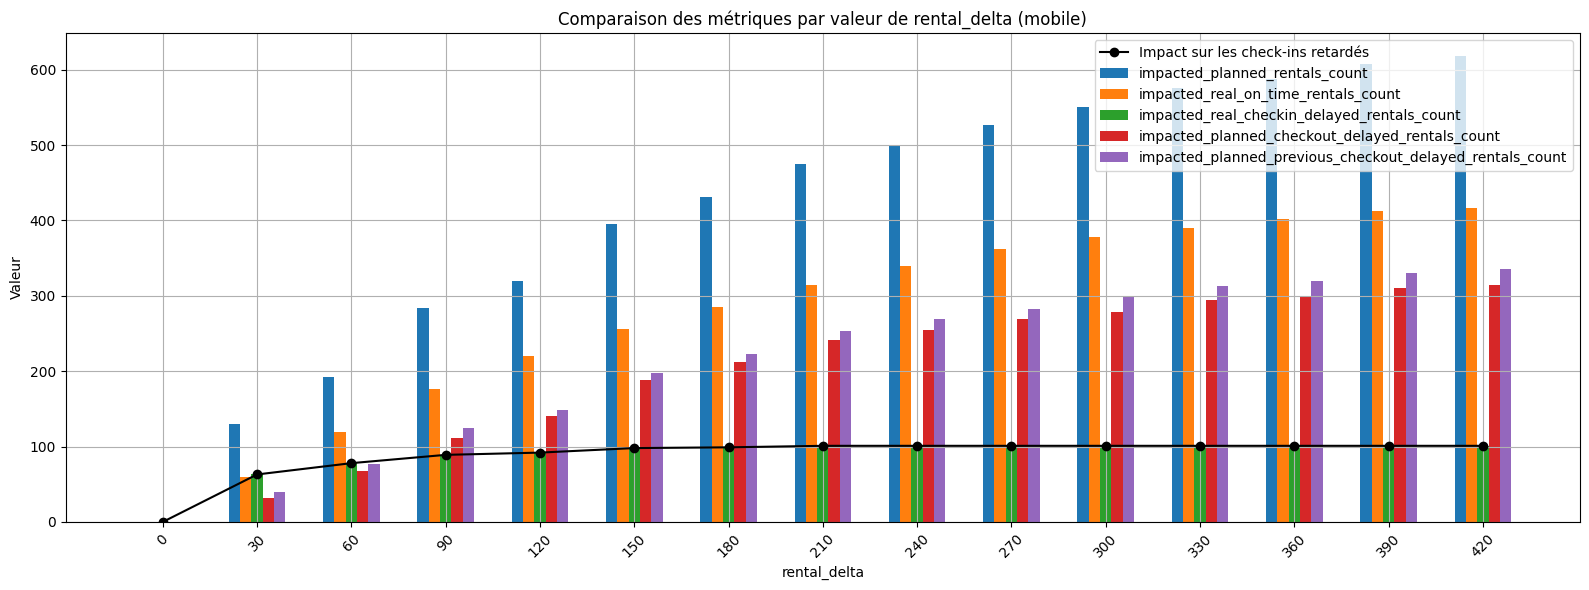

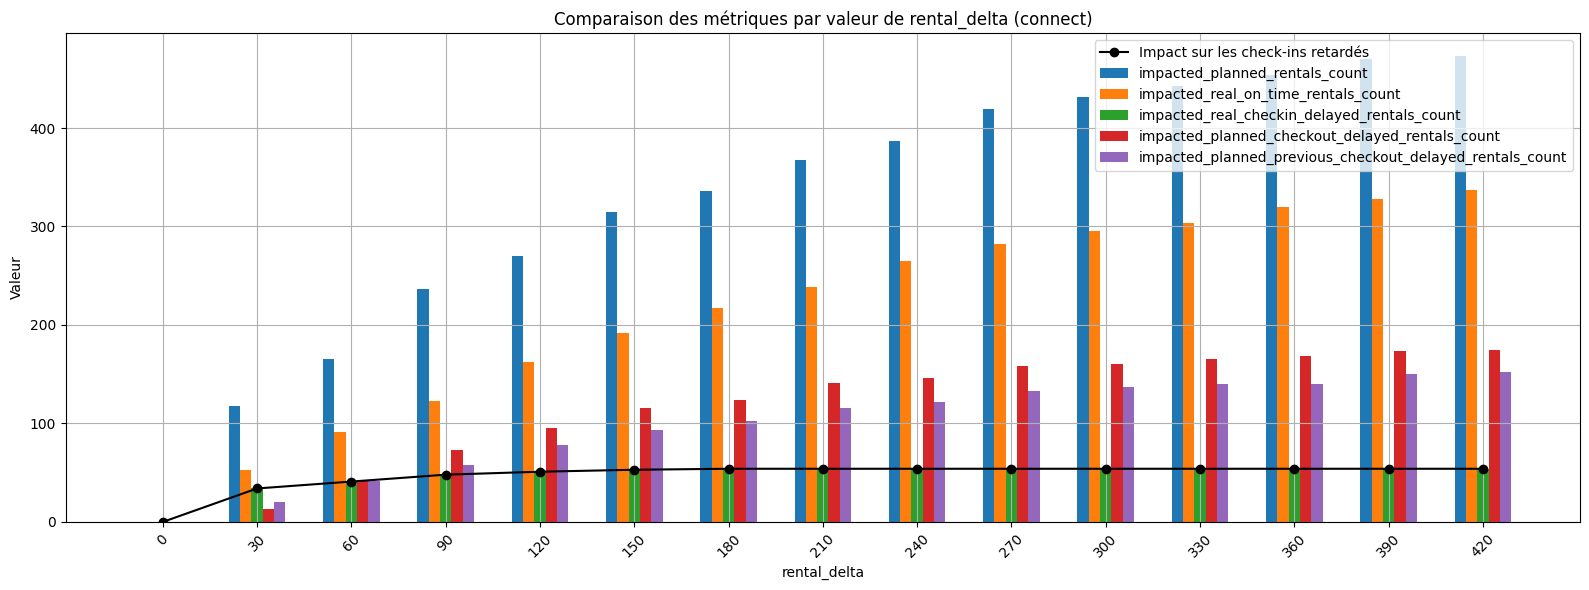

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Colonnes d'intérêt
cols = [
    'impacted_planned_rentals_count',
    'impacted_real_on_time_rentals_count',
    'impacted_real_checkin_delayed_rentals_count',
    'impacted_planned_checkout_delayed_rentals_count',
    'impacted_planned_previous_checkout_delayed_rentals_count',
]

line_col = 'impacted_real_checkin_delayed_rentals_count'

# Trier par rental_delta pour ordre logique
df_sorted = rental_delta_impact_df.sort_values("rental_delta")

# Limiter à N valeurs pour lisibilité (optionnel)
N = 30
df_plot = df_sorted.head(N)  # ou sample(N) pour un échantillon aléatoire

def plot_checkin_type(df, checkin_type):
    plot_df = df[df["checkin_type"] == checkin_type]
    
    x = np.arange(len(plot_df))  # position x pour chaque rental_delta
    width = 0.12                 # largeur de chaque barre
    
    plt.figure(figsize=(16, 6))

    for i, col in enumerate(cols):
        plt.bar(x + i * width, plot_df[col], width, label=col)
        
    # Line plot
    plt.plot(x + width * (len(cols)-1) / 2, plot_df[line_col], color='black', marker='o', linestyle='-', label='Impact sur les check-ins retardés')


    # Ajouter les labels sur l’axe x
    plt.xticks(x + width * (len(cols)-1) / 2, plot_df['rental_delta'], rotation=45)

    plt.xlabel("rental_delta")
    plt.ylabel("Valeur")
    plt.title(f"Comparaison des métriques par valeur de rental_delta ({checkin_type})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


plot_checkin_type(df_plot, "mobile")
plot_checkin_type(df_plot, "connect")


`impacted_real_checkin_delayed_rentals_count` donne une idée du nombre de cas problèmatiques évités. A 30 minutes, la majeure partie est déjà évitée.

### Conclusion

Le choix du delta minimum entre 2 locations peut s'appuyer sur le nombre de conflits évités vs le nombre de locations retardées.
